In [1]:
import numpy as np
import pandas as pd
from itertools import compress
import matplotlib.pyplot as plt
%matplotlib inline
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri

numpy2ri.activate()
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import abm
%load_ext autoreload
%autoreload 2

In [2]:
dat = pd.read_csv('../data_clean/gss18cat.raw', sep='\s+', header=0)
dat.autmean = -dat.autmean
dat.head()

,educ,age,nonwhite,occ17,presmean,autmean
0,19,29,0,2,59.3,0.103448
1,16,29,0,7,35.9,0.083306
2,18,26,0,3,52.4,0.264063
3,12,37,0,12,30.1,0.156604
4,12,30,0,7,35.9,0.083306


In [3]:
n_i = dat.shape[0]
n_j = len(np.unique(dat.occ17))
p_i = 4
p_j = 2
choice = dat.occ17 + 1

# ---- Prepare opp, the opportunity set ----
opp = np.zeros(shape=(n_i, n_j), dtype="bool")
opp[np.arange(n_i), dat.occ17] = True  # people are offered jobs they have!
opp[:, 0] = True                     # Unemployment always offered

In [4]:
# ---- Prepare ww ----
ww = np.empty((n_j, p_j))
for i in range(n_j):
    ww[i, 0] = np.unique(dat.presmean[dat.occ17 == i])
    ww[i, 1] = np.unique(dat.autmean[dat.occ17 == i])

In [5]:
# ---- Prepare xx ----
one = np.ones(n_i)
xx = dat[["educ", "age", "nonwhite"]]
xx = np.column_stack((one, xx))

# Simulate based on real data

In [6]:
n_employee = 1000
n_employer = 4 # Unemployment 1; Professionals, Salaried 3; Craftsmen, Manufacturing 9; Service 14
employee_list = [None] * n_employee
employer_list = [None] * n_employer

In [7]:
my_ww = ww[np.array([0, 2, 8, 13]), :]
my_beta = np.array([[0, 0, 0, 0],
                    [-9, 0.2, 0.15, 1],
                    [-6, 0.2, 0.1, -1],
                    [-12, 0.1, 0.3, 1]])
for i in range(n_employer):
    employer_list[i] = abm.Employer(w=my_ww[i, :], beta=my_beta[i, :])

In [8]:
my_xx = xx[np.random.choice(xx.shape[0], size=n_employee, replace=False), :]
alpha = np.array([0.07, 1])
for i in range(n_employee):
    employee_list[i] = abm.Employee(x=my_xx[i, ], alpha=alpha)

In [9]:
xx.dot(my_beta.T)

array([[ 0.  , -0.85,  0.7 , -1.4 ],
       [ 0.  , -1.45,  0.1 , -1.7 ],
       [ 0.  , -1.5 ,  0.2 , -2.4 ],
       ..., 
       [ 0.  , -0.85,  0.3 ,  0.4 ],
       [ 0.  , -1.25,  0.3 , -1.6 ],
       [ 0.  , -1.85, -2.1 , -2.3 ]])

In [10]:
my_model = abm.Model(n_employer=n_employer, n_employee=n_employee)
my_alpha, beta, ww, xx, choice, true_opp, observed_opp = \
    my_model.matching_process(employer_list=employer_list, employee_list=employee_list)
wa = np.array([ee.wa for ee in employee_list])

In [11]:
np.save("ww.npy", ww)
np.save("xx.npy", xx)
np.save("obs_opp.npy", observed_opp)
np.save("true_opp.npy", true_opp)
np.save("choice.npy", choice.astype('float64'))
np.save("wa.npy", wa)

In [12]:
np.mean(observed_opp, axis=0)

array([ 1.   ,  0.215,  0.232,  0.165])

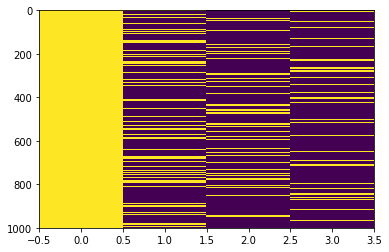

In [13]:
plt.imshow(observed_opp, aspect="auto")

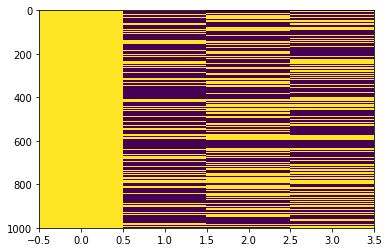

In [14]:
plt.imshow(true_opp, aspect="auto")

In [15]:
ee = employee_list[4]
ee.wa

array([ 1.80607255,  4.98486382,  3.17083715,  4.6578177 ])

In [16]:
true_opp[4, :]

array([ 1.,  0.,  0.,  0.])

In [17]:
choice[4]

0

In [29]:
class Er:
    
    def __init__(self, wfunc):
        self.wfunc = wfunc
        
    def offer(self, ee):
        return self.wfunc(ee)

In [30]:
my_er = Er(wfunc = lambda x: 12 + 0.5 * x)

In [31]:
my_er.offer(5)

14.5